In [1]:
# from torchsummary import summary
# from torchviz import make_dot
import albumentations as A
import mlflow
import torch.nn as nn
import torch.optim as optim
import tqdm
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import PolynomialLR

from DiceBCELoss import DiceBCELoss
from model import UNetPlusPlus, ResNeXtBottleneck
from utils import *

In [2]:
EXPERIMENT_NAME = "CS679_Project"

In [3]:
# experiment_id = mlflow.create_experiment(f"{EXPERIMENT_NAME}")
experiment = mlflow.get_experiment_by_name(f"{EXPERIMENT_NAME}")
mlflow.set_experiment(f"{EXPERIMENT_NAME}")

<Experiment: artifact_location='file:///c:/Users/student01/Desktop/project_Kamurocho/mlruns/720046021139205273', creation_time=1744269385412, experiment_id='720046021139205273', last_update_time=1744269385412, lifecycle_stage='active', name='CS679_Project', tags={}>

In [ ]:
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 12
epochs = 300
pin_memory = True

# Data

Path: \
stenosis_train = ARCADE('dataset/stenosis/train')\
syntax__test = ARCADE('dataset/syntax_/test')\
syntax__val = ARCADE('dataset/stenosis/val')\
syntax_train = ARCADE('dataset/syntax/train')\
syntax_test = ARCADE('dataset/syntax/test')\
syntax_val = ARCADE('dataset/syntax/val')

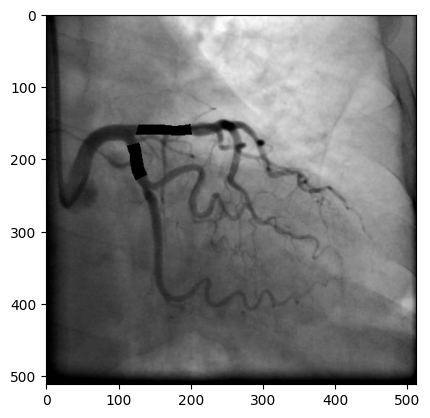

In [5]:
sample = ARCADE('dataset/stenosis/train')[10]
image = sample[0].reshape((512, 512))
mask = sample[1].reshape((512, 512))

plot_image_with_mask(image, mask)

In [6]:
image.shape

(512, 512)

In [7]:
mask.shape

(512, 512)

In [8]:
train_transform = A.Compose([
    A.VerticalFlip(p=0.5),  
    A.HorizontalFlip(p=0.5),  
    A.ShiftScaleRotate(
        shift_limit=0.3,  
        scale_limit=0.5,  
        rotate_limit=30, 
        p=1.0 
    ),
    A.Affine(shear=5, p=1.0),  
    A.Perspective(scale=(0.001, 0.001), p=1.0),  
     ToTensorV2()
])
val_transform = A.Compose([
    ToTensorV2()  # This ensures the output is in the format PyTorch expects
])

# stenosis_train, stenosis_test, stenosis_val = get_loaders('dataset/stenosis/train', 'dataset/stenosis/test',
#                                                           'dataset/stenosis/val', batch_size, train_transform,
#                                                           val_transform, val_transform)

syntax_train, syntax_test, syntax_val = get_loaders('dataset/syntax/train', 'dataset/syntax/test', 'dataset/syntax/val', batch_size, train_transform,
                                                          val_transform, val_transform)

C:\Users\student01\anaconda3\envs\SYDE\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# Model

In [9]:
# model = UNetPlusPlus()
# summary(model, (1, 512, 512))

In [10]:
# os.environ["PATH"] += os.pathsep + 'F:/Program Files/Graphviz/bin/'
# x = torch.randn(1, 1, 512, 512)
# y = model(x)
# make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render("rnn_torchviz", format="png")

# Training

In [11]:
model = UNetPlusPlus(block=ResNeXtBottleneck).to(device)

In [ ]:
criterion = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.amp.GradScaler()

best_f1, best_iou, best_dsc = 0.0, 0.0, 0.0

mlflow.start_run()
mlflow.log_param("learning_rate", lr)
mlflow.log_param("epochs", epochs)
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("optimizer", "Adam")
mlflow.log_param("scheduler", "GradScaler")

for epoch in tqdm.trange(epochs):
    # loop = tqdm.tqdm(stenosis_train, leave=True, position=0)
    # for batch_idx, (data, targets) in enumerate(loop):
    for batch_idx, (data, targets) in enumerate(syntax_train):
        data = data.to(device=device)
        targets = targets.float().to(device=device)

        # forward
        predictions = model(data)
        loss = criterion(predictions, targets)
        mlflow.log_metric("Loss", loss.item(), step=epoch * batch_size + batch_idx + 1)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    avg_f1, avg_iou, avg_dsc = track_metric(syntax_val, model, device=device)
    
    mlflow.log_metric("Avg F1", avg_f1, step=epoch)
    mlflow.log_metric("Avg IoU", avg_iou, step=epoch)
    mlflow.log_metric("Avg DSC", avg_dsc, step=epoch)

    
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_iou = avg_iou
        best_dsc = avg_dsc
        print(f"Best F1: {best_f1}, Best IoU: {best_iou}, Best DSC: {best_dsc}")
        torch.save(model, "./checkpoint/best.pth".format(epoch))
        mlflow.log_artifact("./checkpoint/best.pth".format(epoch))
    else:
        print(f"F1: {avg_f1}, IoU: {avg_iou}, DSC: {avg_dsc}")
        torch.save(model, "./checkpoint/last.pth".format(epoch))
        mlflow.log_artifact("./checkpoint/last.pth".format(epoch))
mlflow.end_run()

  0%|          | 0/300 [00:00<?, ?it/s]